<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/Waterpumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

competition: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

geographical data: https://heartbeat.fritz.ai/working-with-geospatial-data-in-machine-learning-ad4097c7228d

optional data quality report: https://github.com/benjimr/Data-Summarizer-for-a-Data-Quality-Report/blob/master/Reporter.py

data quality report: https://github.com/ColinLeverger/machine-learning-python

Tanzania maps: https://www.researchgate.net/figure/Map-of-the-United-Republic-of-Tanzania-human-population-density-map-and-Anopheles_fig1_328491768

###**1.1 Loading Libraries**

In [2]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [3]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

###**1.2 Loading data**

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/train_labels.csv')
train_values = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/train_values.csv', parse_dates = ['date_recorded' ])
test_values = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/test_values.csv', parse_dates = ['date_recorded' ])

In [6]:
#merge train values and train labels to single dataset
train= pd.merge(train_labels , train_values, on='id')


In [7]:
#concatenate train and test for easier data minipulation
raw = pd.concat([train, test_values])
raw.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [49]:
#convert faulty datatypes
raw[['region_code','district_code', 'num_private']] = raw[['region_code','district_code', 'num_private']].astype('object')

In [50]:
raw.dtypes

id                                int64
status_group                     object
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                      object
basin                            object
subvillage                       object
region                           object
region_code                      object
district_code                    object
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64


In [11]:
#divide features into numerical and cateogorical for ease of describtion
numerical = ['id', 'amount_tsh', 'date_recorded', 'gps_height',  'longitude', 'latitude', 
             'population', 'construction_year' ]

categorical = ['status_group', 'funder', 'installer','wpt_name','num_private',  'basin', 'subvillage', 'region', 'region_code',
               'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 
               'scheme_name', 'permit', 'extraction_type', 'extraction_type_group','extraction_type_class',
               'management', 'management_group', 'payment','payment_type', 'water_quality', 'quality_group', 'quantity',
               'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


print("Number of numerical features: {}".format(len(numerical)))
print("Number of categorical features: {}".format(len(categorical)))


Number of numerical features: 8
Number of categorical features: 33


###**2.1 Exploring the data**

####**2.1.1 Numerical data**

In [12]:
raw[numerical].head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,population,construction_year
0,69572,6000.0,2011-03-14,1390,34.938093,-9.856322,109,1999
1,8776,0.0,2013-03-06,1399,34.698766,-2.147466,280,2010
2,34310,25.0,2013-02-25,686,37.460664,-3.821329,250,2009
3,67743,0.0,2013-01-28,263,38.486161,-11.155298,58,1986
4,19728,0.0,2011-07-13,0,31.130847,-1.825359,0,0


In [13]:
#raw[numerical].describe()

In [14]:
#print percentage of missing numerical datapoints
#round(raw[numerical].isna().sum()*100/raw[numerical].isna().count()).sort_values(ascending=False)

In [15]:
#explore the cardinality of numerical features
#for column in raw[numerical]:
  #unique = raw[column].nunique()
  #print(column,":", unique)
 

####**2.1.2 Data Quality report Numerical features**


In [16]:
data_types = pd.DataFrame(
    raw[numerical].dtypes,
    columns=['Data Type'])

missing_data = pd.DataFrame(
    raw[numerical].isnull().sum(),
    columns=['Missing Values'])

unique_values = pd.DataFrame(
    columns=['Unique Values']
)
for row in list(raw[numerical].columns.values):
    unique_values.loc[row] = [raw[numerical][row].nunique()]

maximum_values = pd.DataFrame(
    columns=['Maximum Value'])
for row in list(raw[numerical].columns.values):
    maximum_values.loc[row] = [raw[numerical][row].max()]

minimum_values = pd.DataFrame(
    columns=['Minimum Value'])
for row in list(raw[numerical].columns.values):
    minimum_values.loc[row] = [raw[numerical][row].min()]

count_values = pd.DataFrame(
    columns=['Count Value'])
for row in list(raw[numerical].columns.values):
    count_values.loc[row] = [raw[numerical][row].count()]

mean_values = pd.DataFrame(
    columns=['Mean Value'])
for row in list(raw[numerical].columns.values):
    mean_values.loc[row] = [raw[numerical][row].mean()]

quartile_1 = pd.DataFrame(
    columns=['1st Quartile'])
for row in list(raw[numerical].columns.values):
    quartile_1.loc[row] = [raw[numerical][row].quantile(0.25)]

median = pd.DataFrame(
    columns=['Median'])
for row in list(raw[numerical].columns.values):
    median.loc[row] = [raw[numerical][row].quantile(0.5)]

quartile_3 = pd.DataFrame(
    columns=['3rd Quartile'])
for row in list(raw[numerical].columns.values):
    quartile_3.loc[row] = [raw[numerical][row].quantile(0.75)]

dq_report = data_types.join(count_values).join(missing_data).join(unique_values).join(minimum_values).join(maximum_values).join(mean_values).join(quartile_1).join(median).join(quartile_3)
dq_report['Missing %'] = (dq_report['Missing Values'] / len(raw[numerical]) *100)
dq_report

,Data Type,Count Value,Missing Values,Unique Values,Minimum Value,Maximum Value,Mean Value,1st Quartile,Median,3rd Quartile,Missing %
id,int64,74250,0,74250,0,74249,37124.5,18562.2,37124.5,55686.8,0.0
amount_tsh,float64,74250,0,102,0,350000,318.686,0,0,20,0.0
date_recorded,datetime64[ns],74250,0,369,2001-03-26 00:00:00,2013-12-03 00:00:00,2012-03-28 09:51:49.527267072,2011-04-01 00:00:00,2012-10-10 00:00:00,2013-02-09 00:00:00,0.0
gps_height,int64,74250,0,2456,-90,2777,665.667,0,364,1317,0.0
longitude,float64,74250,0,71870,0,40.3452,34.0743,33.0868,34.9075,37.1817,0.0
latitude,float64,74250,0,71869,-11.6494,-2e-08,-5.70177,-8.52567,-5.02654,-3.32506,0.0
population,int64,74250,0,1128,0,30500,180.751,0,25,215,0.0
construction_year,int64,74250,0,55,0,2013,1298.46,0,1986,2004,0.0


In [17]:
unique = raw[categorical].apply(lambda x: len(x.unique()))
unique.head()

status_group        4
funder           2141
installer        2411
wpt_name        45684
num_private        68
dtype: int64

In [18]:
median = raw[categorical].apply(lambda x: (x.mode()))
median.head()

,status_group,funder,installer,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,Government Of Tanzania,DWE,none,0,Lake Victoria,Shuleni,Iringa,11,1,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### **2.1.3 Density Plot Numerical features**

In [19]:
def kdeplotter (dataset, feature, rows, columns):
    fig, axes = plt.subplots(nrows=rows,ncols=columns, figsize = (30,12))
    plot = 0
    for i in range(rows):
        for j in range(columns):
             ax = sns.kdeplot(data = dataset, x =feature[plot] , ax = axes[i][j],    shade = True, color  = "black" )
             ax.set_title(feature[plot])
             ax.set_xlabel("")
             plot +=1

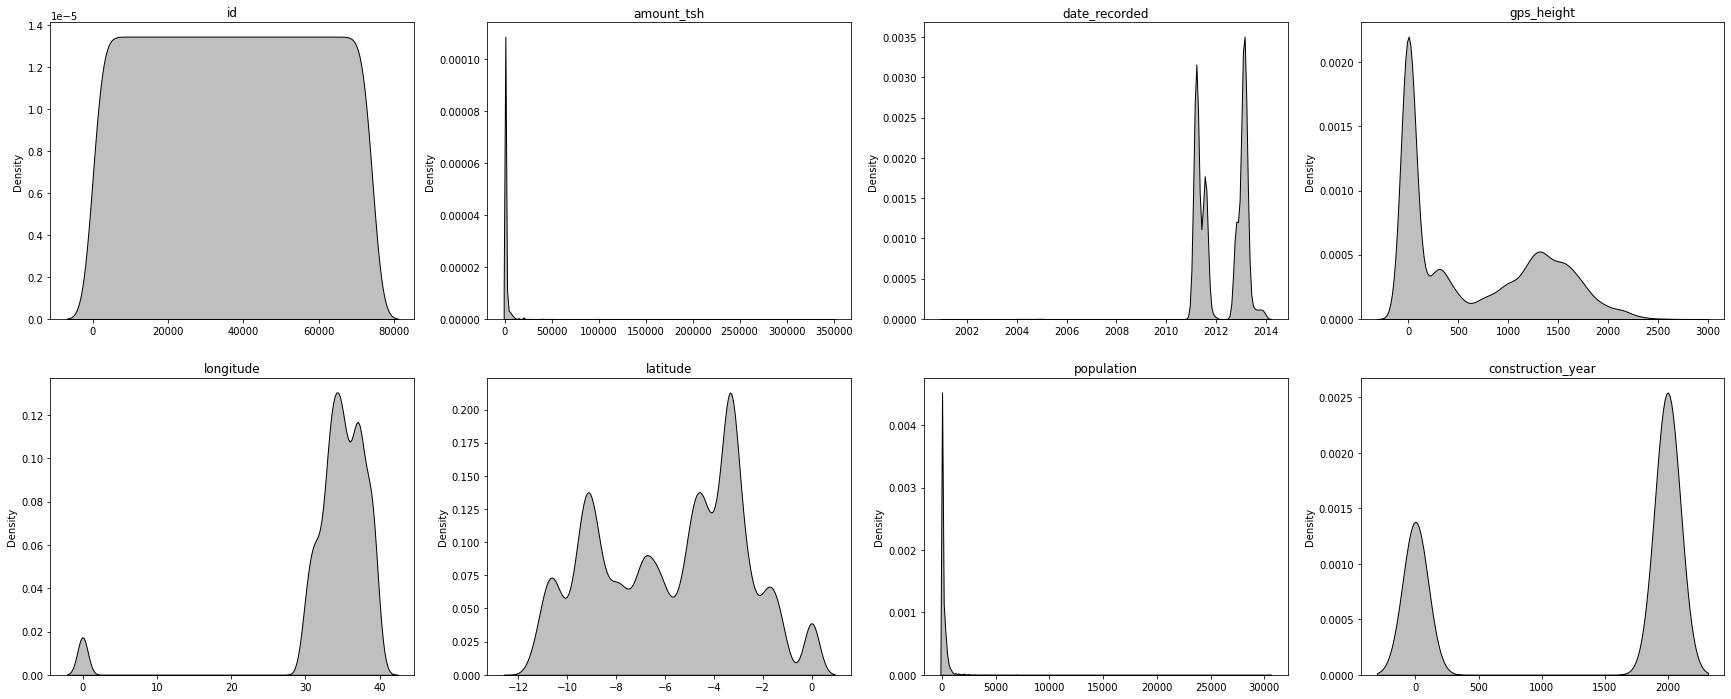

In [20]:
kdeplotter(raw, raw[numerical].columns, 2,4)

#### **2.1.4 Histograms Numerical features**

In [21]:
def histplotter (dataset, feature, rows, columns):
    fig, axes = plt.subplots(nrows=rows,ncols=columns, figsize = (30,10))
    plot = 0
    for i in range(rows):
        for j in range(columns):
             ax = sns.histplot(data = dataset, x =feature[plot] , ax = axes[i][j], color  = "chocolate", bins = 30 )
             ax.set_title(feature[plot])
             ax.set_xlabel("")
             plot +=1

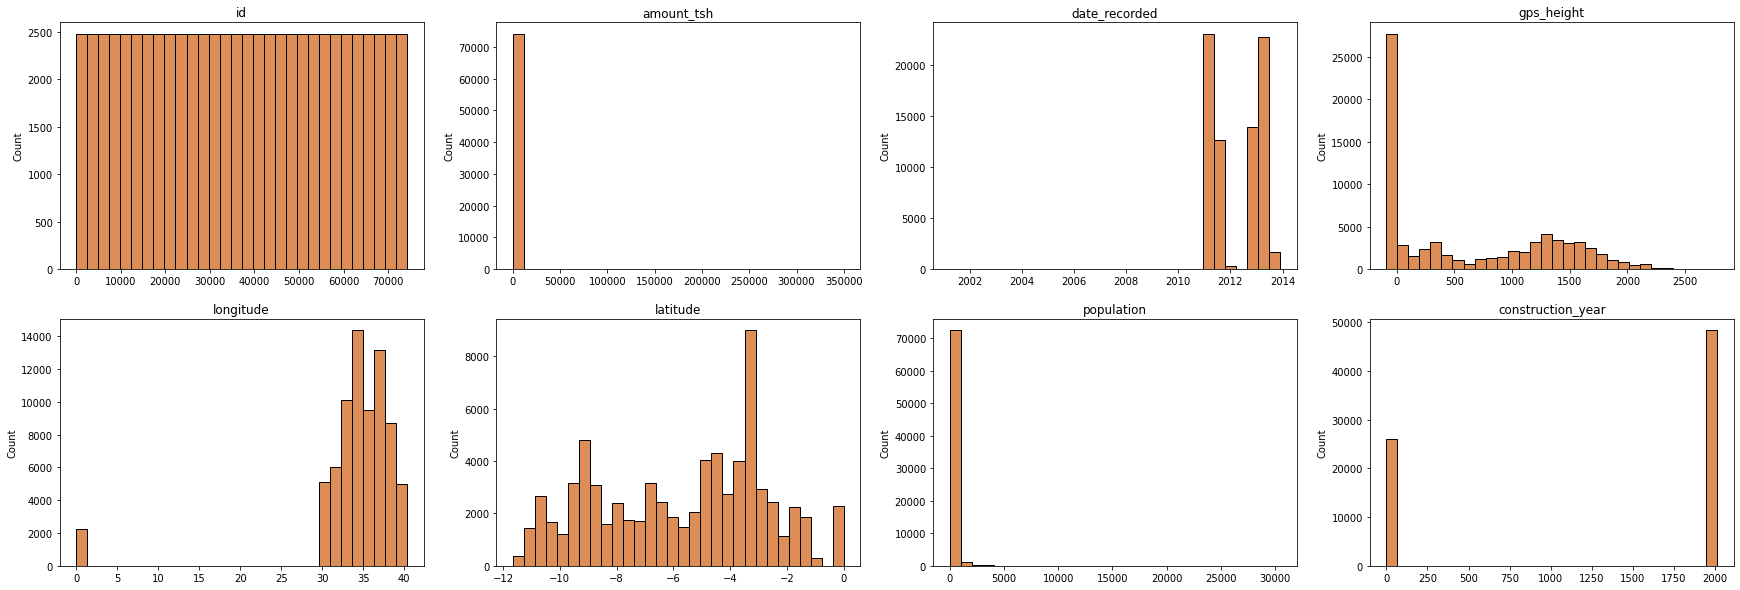

In [22]:
histplotter (raw, raw[numerical].columns, 2,4)

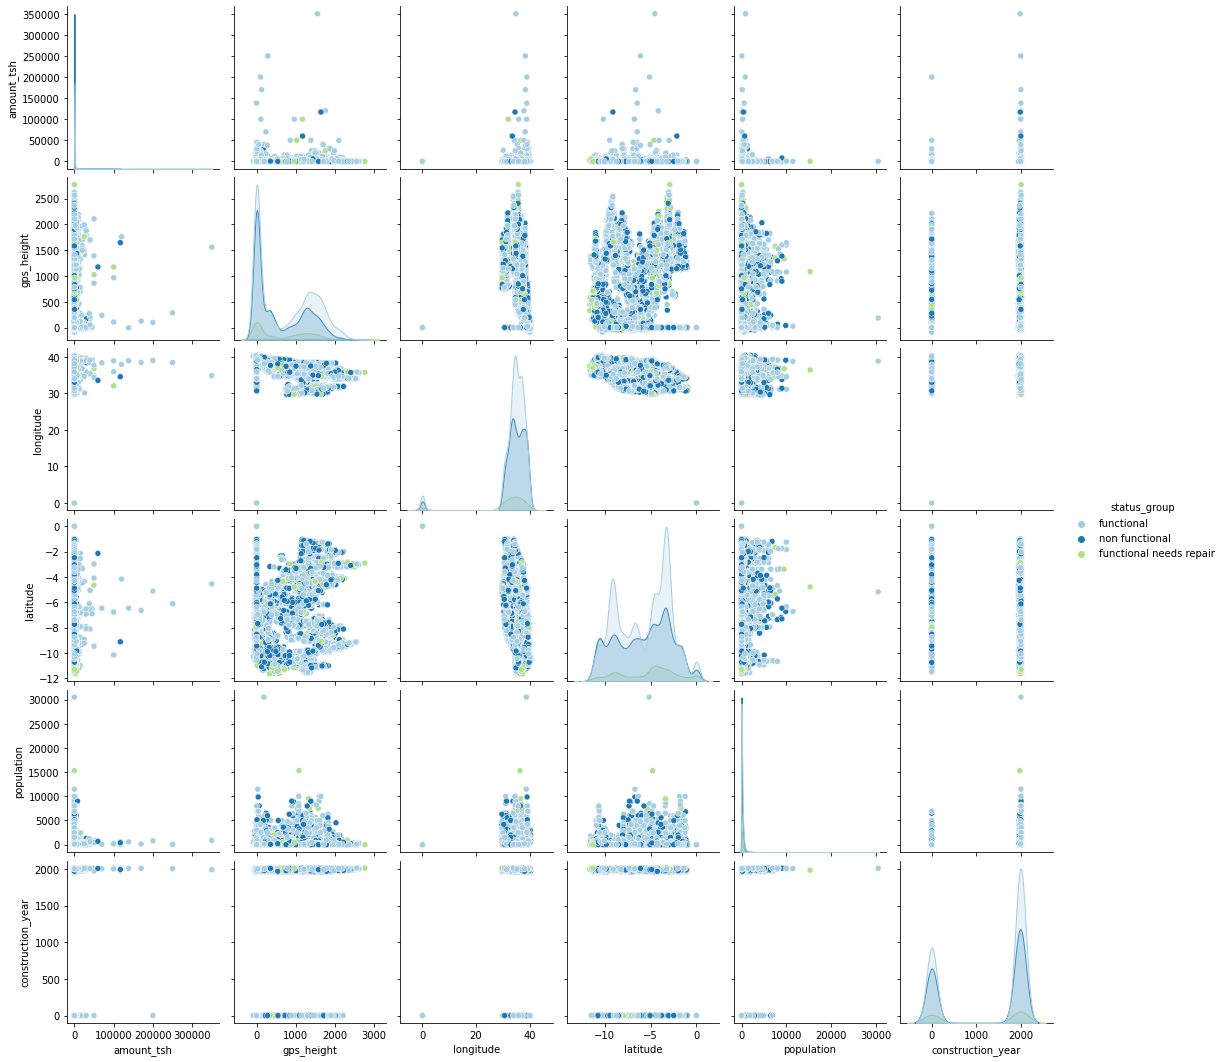

In [100]:
numerical_pair = [ 'amount_tsh', 'gps_height',  'longitude', 'latitude', 
             'population', 'construction_year', 'status_group' ]

sns.pairplot(raw[numerical_pair], hue = 'status_group', kind = 'scatter', palette = 'Paired')

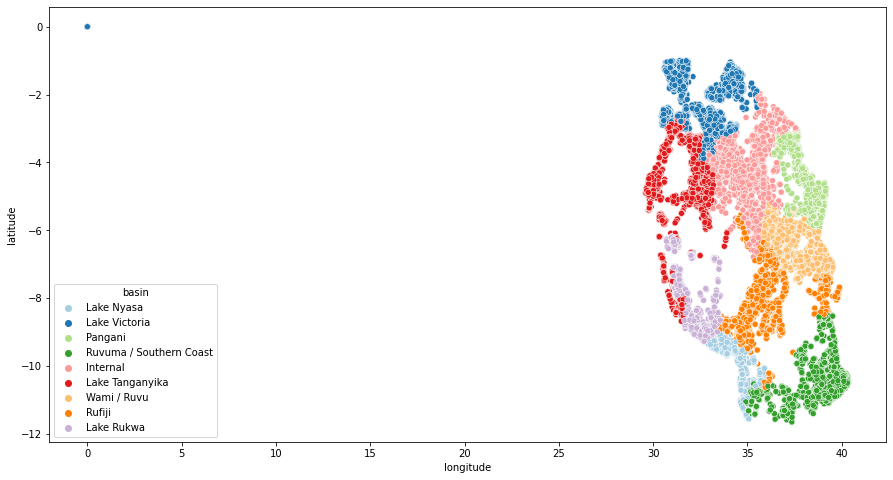

In [24]:
plt.figure(figsize = (15,8))
sns.scatterplot(x= raw['longitude'], y = raw['latitude'], hue = raw['basin'], palette='Paired')
plt.show()


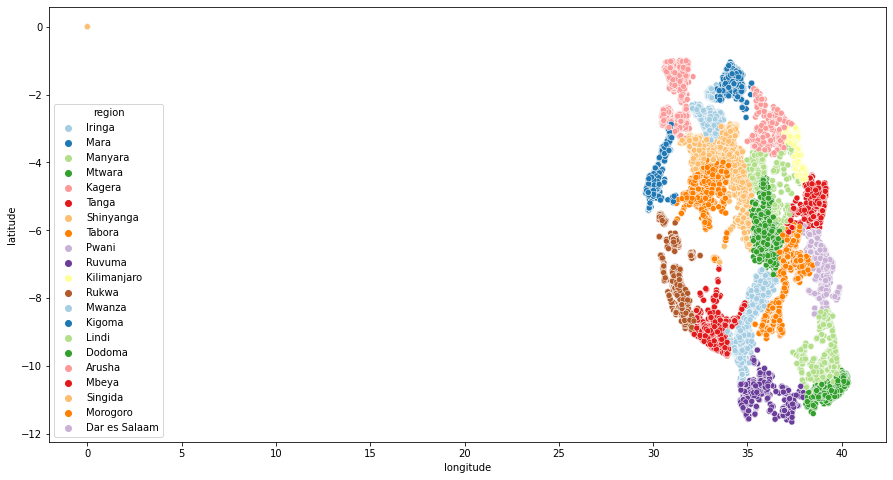

In [92]:
plt.figure(figsize = (15,8))
sns.scatterplot(x= raw['longitude'], y = raw['latitude'], hue = raw['region'], palette='Paired')
plt.show()


####**2.1.1 Categorical data**

In [28]:
raw[categorical].head()

,status_group,funder,installer,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,Roman,Roman,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,Grumeti,GRUMETI,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,NaN,GeoData Consultants Ltd,Other,NaN,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,Lottery Club,World vision,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,Unicef,UNICEF,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,True,GeoData Consultants Ltd,VWC,NaN,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,Action In A,Artisan,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,True,GeoData Consultants Ltd,NaN,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [29]:
# print absolute number  of missing continious data points
#print(raw[categorical].isna().sum().sort_values(ascending=False))

In [30]:
#print percentage of missing numerical datapoints
#round(raw[categorical].isna().sum()*100/raw[categorical].isna().count()).sort_values(ascending=False)

In [31]:
#print percentage of missing numerical datapoints
#round(raw[categorical].isna().sum()*100/raw[categorical].isna().count()).sort_values(ascending=False)

In [32]:
#value = raw['status_group'].value_counts()
#value

In [33]:
#explore the cardinality of numerical features
#for column in raw[categorical]:
  #mode = raw[column].value_counts()
  #print(mode)
 

In [34]:
#how many unique gps coordinates are there?
#temp = raw.copy()
#temp['location'] = temp['longitude'].astype(str) + '-' + temp['latitude'].astype(str)
#temp['location'].nunique()


In [35]:
data_types = pd.DataFrame(
    raw[categorical].dtypes,
    columns=['Data Type'])

count_values = pd.DataFrame(
    columns=['Count Value'])
for row in list(raw[categorical].columns.values):
    count_values.loc[row] = [raw[categorical][row].count()]

missing_data = pd.DataFrame(
    raw[categorical].isnull().sum(),
    columns=['Missing Values'])

unique_values = pd.DataFrame(
    columns=['Unique Values'])
for row in list(raw[categorical].columns.values):
    unique_values.loc[row] = [raw[categorical][row].nunique()]

mode_values = pd.DataFrame(
    columns=['Mode'])
for row in list(raw[categorical].columns.values):
    mode_values.loc[row] = [raw[categorical][row].mode()[0]]
    mode = mode_values.loc[row]

#mode frequency
listModeFreq = []
for row in categorical:
    mode = raw[row].mode().iat[0]
    ModeFreq = raw[row].value_counts()[mode]
    #print(x, mode, raw[x].value_counts()[mode])
    listModeFreq .append(ModeFreq )
listModeFreq  = np.array(listModeFreq )

dq_report = data_types.join(count_values).join(missing_data).join(unique_values).join(mode_values)
dq_report['Mode freq.'] = listModeFreq 
dq_report['Mode %'] = (dq_report['Mode freq.'] / dq_report['Count Value']*100) 
dq_report['Missing %'] = (dq_report['Missing Values'] / len(raw[categorical]) *100)
dq_report  

,Data Type,Count Value,Missing Values,Unique Values,Mode,Mode freq.,Mode %,Missing %
status_group,object,59400,14850,3,functional,32259,54.3081,20.000000
funder,object,69746,4504,2140,Government Of Tanzania,11299,16.2002,6.065993
installer,object,69718,4532,2410,DWE,21751,31.1985,6.103704
wpt_name,object,74250,0,45684,none,4440,5.9798,0.000000
num_private,object,74250,0,68,0,73299,98.7192,0.000000
basin,object,74250,0,9,Lake Victoria,12871,17.3347,0.000000
subvillage,object,73780,470,21425,Shuleni,646,0.875576,0.632997
region,object,74250,0,21,Iringa,6599,8.88754,0.000000
region_code,object,74250,0,27,11,6608,8.89966,0.000000
district_code,object,74250,0,20,1,15299,20.6047,0.000000


In [71]:
#check how region_code and region relate
for x in raw['region_code'].unique():
  check = raw[raw['region_code']==x]
  count = check['region'].value_counts()
  print(x)
  print(count)

5
Morogoro    5038
Tanga         41
Name: region, dtype: int64
2
Arusha    3709
Name: region, dtype: int64
4
Tanga    3145
Name: region, dtype: int64
63
Series([], Name: region, dtype: int64)
1
Dodoma    2779
Name: region, dtype: int64
8
Lindi    375
Name: region, dtype: int64
3
Kilimanjaro    5494
Name: region, dtype: int64
6
Pwani    2032
Name: region, dtype: int64
43
Series([], Name: region, dtype: int64)
7
Dar es Salaam    1020
Name: region, dtype: int64
23
Series([], Name: region, dtype: int64)
33
Series([], Name: region, dtype: int64)
53
Series([], Name: region, dtype: int64)
62
Series([], Name: region, dtype: int64)
60
Pwani    1298
Name: region, dtype: int64
30
Series([], Name: region, dtype: int64)
13
Singida    2536
Name: region, dtype: int64
0
Series([], Name: region, dtype: int64)
80
Lindi    1536
Name: region, dtype: int64
67
Series([], Name: region, dtype: int64)


### Data Visualization Categorical features

In [36]:
#create a list of categorical features with low cardinality
low_cardinal = dq_report[dq_report['Unique Values'] <=50]
cardinal_index = low_cardinal.index
low_cardinal_list = cardinal_index.to_list()

In [37]:
def countplotter (dataset, feature, rows, columns):
    fig, axes = plt.subplots(nrows=rows,ncols=columns, figsize = (30,60))
    plot = 0
    for i in range(rows):
        for j in range(columns):
             ax = sns.countplot(data = dataset, x =feature[plot] , ax = axes[i][j], palette='YlOrRd' )
             ax.set_title(feature[plot])
             ax.set_xlabel("")
             ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
             plot +=1

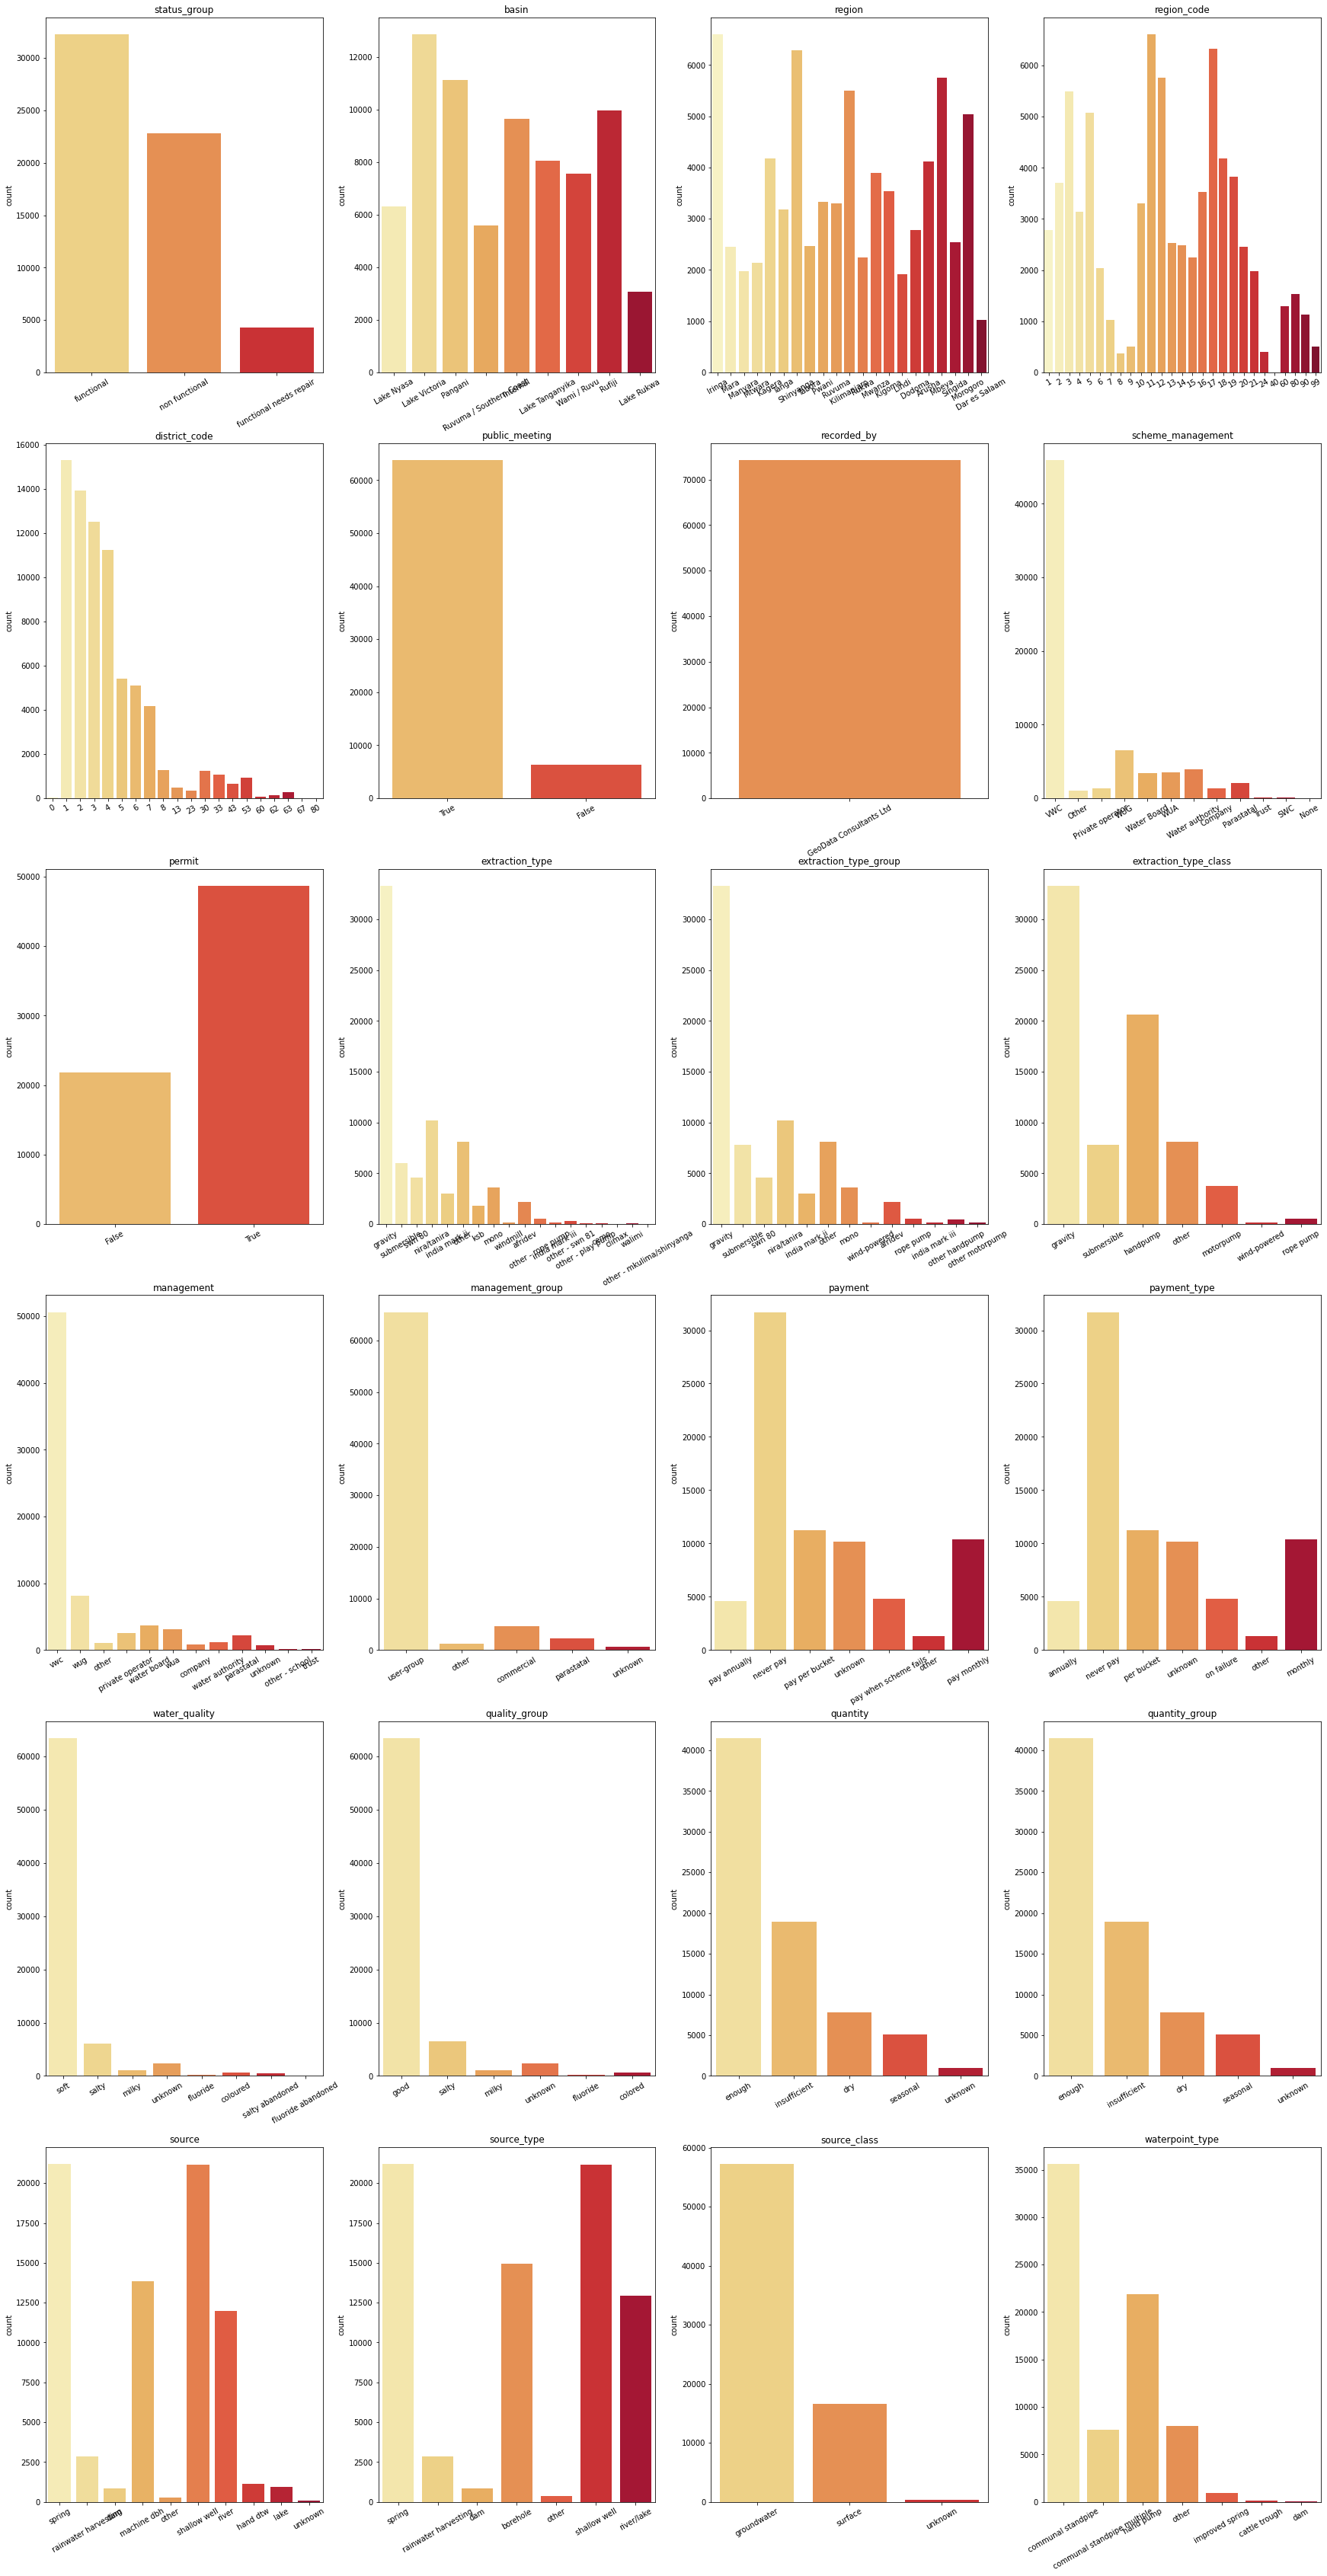

In [85]:
countplotter (raw, raw[low_cardinal_list].columns, 6,4)

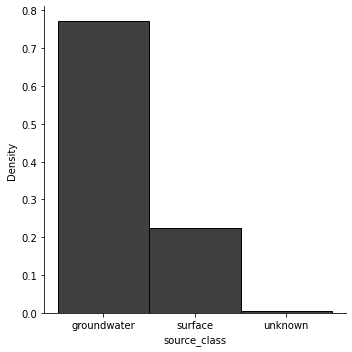

In [43]:
sns.displot(raw, x="source_class", stat = 'density', color = 'black')

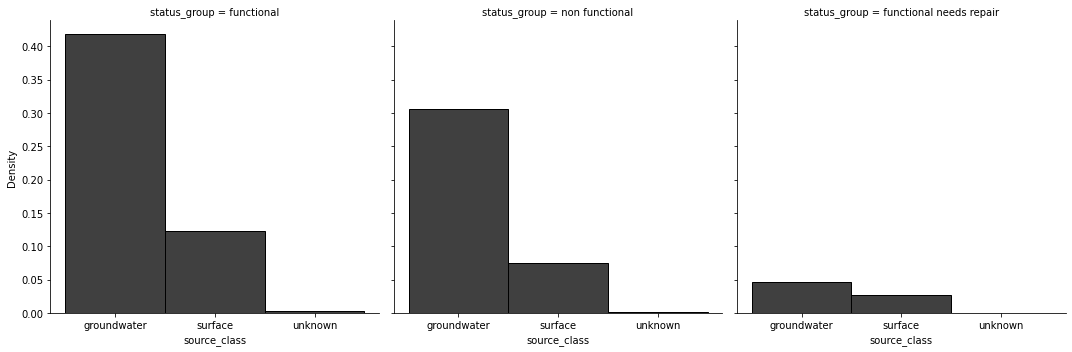

In [60]:
sns.displot(raw, x="source_class", stat = 'density', col = 'status_group', color = 'black', discrete = True)

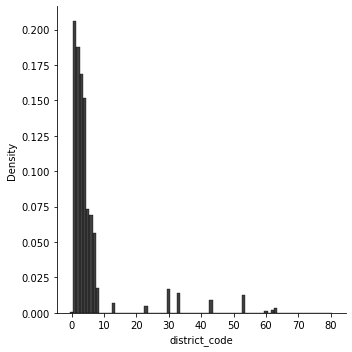

In [59]:
sns.displot(raw, x="district_code", stat = 'density', color = 'black', discrete=True)

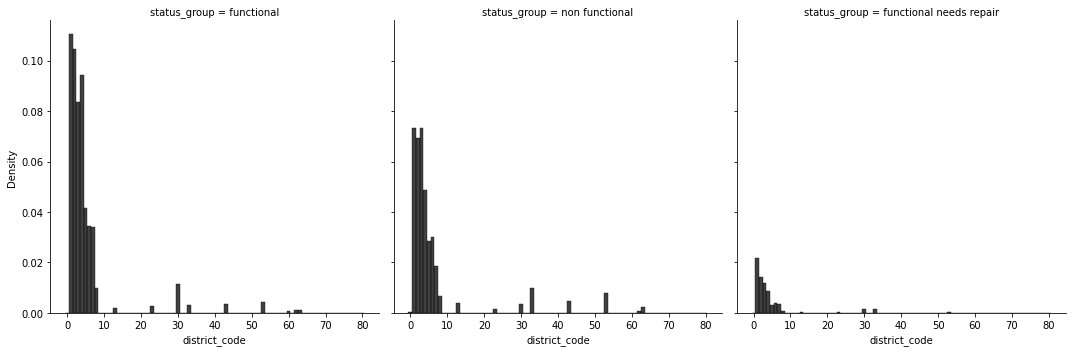

In [55]:
sns.displot(raw, x="district_code", stat = 'density', col = 'status_group', color = 'black', discrete=True)